In [49]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as rnd
import random
import math
import copy

## 0. Parameters settings

In [50]:
num_pop = 100
dimension = 2
size = 7 #(-100<= X <=100 by binary)

crossover_prob = 0.7 # 0.7, 0.8, 0.9
mutation_prob = 0.05 # 0.01, 0.03, 0.05

function_selected = "Rastrigin" #Sphere #Rastrigin 

## 1. Functions

### 1.1. About chromosomes

In [51]:
"""
Generate random solution
"""
def generate_random_solution(size):
    solution = []
    chromosome = []
    sign = []
    
    # Chromosome
    current_size = 0
    while current_size < size:
        chromosome.append(random.randint(0,1))
        current_size = current_size + 1
    
    # Sign + -
    sign_candidate = [-1, 1]
    sign.append(random.choice(sign_candidate))

    # Merge solution
    solution.append(chromosome)
    solution.append(sign)
    # print(solution)

    return solution

"""
Chromosome genotype solution value function
"""

def chromosome_bin_to_decimal(chromosome): 
    #
    power = len(chromosome[0])-1    
    sum = 0
    
    #
    for idx in range(0,len(chromosome[0])):
        sum = sum + (chromosome[0][idx]) * (2**power)
        power = power - 1
    
    return sum * chromosome[1][0]


### 1.2. Objective functions

In [52]:
"""
Sphere function(objective)
input: decimal
"""
def Sphere_function(x):
    return x**2

def Rastrigin_function(x):
    return (x**2 - 10 * math.cos(2*(math.pi)*x) + 10)


In [53]:
"""
Calculate objective function and judge the best solution
"""

def calculate_objective_function(solution_set):

    value_set = []
    for sol_idx in range(0, len(solution_set)):
        
        sum = 0
        if function_selected == 'Sphere':    
            for dim in range(0,dimension):
                sum = sum + Sphere_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
            
        elif function_selected == 'Rastrigin':    
            for dim in range(0,dimension):
                sum = sum + Rastrigin_function(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
            value_set.append(sum)
        else:
            print("PLEASE SET YOUR FUNCTION")

    # print(value_set)
    
    return value_set

### 1.3. About selection

In [54]:
"""
Calculate objective function and compose selection probability (1st: 50%, 2nd: 25%, 3rd: 12.5% ...)
"""

def calculate_obj_and_compose_selection_probability(solution_set):

    value_set = calculate_objective_function(solution_set)
    
    # Ascending
    temp_df = pd.DataFrame({"index":(range(0,num_pop)), "obj.val": value_set})
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    increasing_index = temp_df['index'].values.tolist()
       
    #
    selection_prob = [-999 for i in range(0,num_pop)]
    sum1_idx = 0
    for count in range(0,(num_pop-1)):
        #
        # print(f'{count}: {increasing_index}')
        where_point = increasing_index.index(count)
        selection_prob[where_point] = 0.5*(0.5)**(count)
        sum1_idx = sum1_idx + 0.5*(0.5)**(count)
    
    where_point = increasing_index.index(num_pop-1)
    selection_prob[where_point] = 1 - sum1_idx
    
    # print(f'selection_prob: {selection_prob}')
            
    return selection_prob



In [55]:
"""
Calculate objective function and compose selection probability based on reciprocal of fitness values
"""
def calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set):
    
    value_set = calculate_objective_function(solution_set)
    # print(value_set)
    
    # Reciprocal
    value_recip_set = []
    for v in value_set:
        if v == 0:
            value_recip_set.append(0)
        else:
            value_recip_set.append(1/v)
    
    denom = np.sum(value_recip_set)
    selection_prob = []
    for i in value_recip_set:
        selection_prob.append(i/denom)
    
            
    return selection_prob

### 1.4. Crossver and Mutation

In [56]:
"""
One-point crossover
: between same dimension

"""
def execute_crossover_standard(solution_1, solution_2):
    
    solution_1_tmp = copy.deepcopy(solution_1)
    solution_2_tmp = copy.deepcopy(solution_2)
    
    # Crossover
    dim = 0
    while dim < dimension:
        
        # Save current solutions
        current_sol1 = solution_1_tmp[dim][0]
        current_sol2 = solution_2_tmp[dim][0]
        # print(f'{current_sol1}\n{current_sol2}')
        
        # Copy the new solution from the current solutions
        new_sol1 = copy.deepcopy(current_sol1)
        new_sol2 = copy.deepcopy(current_sol2)
        
        # Find location for one-point crossover
        point_loc = random.randint(1,(len(current_sol1)-1))
        # print(f'point_loc: {point_loc}')
        for loc_idx in range(0, point_loc):
            
            new_sol1[loc_idx], new_sol2[loc_idx] = new_sol2[loc_idx], new_sol1[loc_idx]
        
        # print(f'{new_sol1}\n{new_sol2}')
        
        # Replace current with new solution
        solution_1_tmp[dim][0] = new_sol1
        solution_2_tmp[dim][0] = new_sol2
        
        # Update
        dim = dim + 1

    # print(f'{solution_1_tmp}\n{solution_2_tmp}')
    return solution_1_tmp, solution_2_tmp

"""
Modified crossover: crop & merge
"""
def execute_crossover_modified(solution_1, solution_2):
    
    return 1


"""
Standard mutation
: select only one
"""
def execute_mutation_standard(new_solution_1, new_solution_2):

    remember_signal = -99
    # Select
    if random.random() <= 0.5:
        mutation_target_chromosome = copy.deepcopy(new_solution_1)
        remember_signal = 1
    else:
        mutation_target_chromosome = copy.deepcopy(new_solution_2)
        remember_signal = 2
        
    # print("!: ",remember_signal)

    # Choose the location randomly along all dimension 
    dim = 0
    while dim < dimension:
        temp_chromosome = mutation_target_chromosome[dim][0]
        # print(temp_chromosome)
        
        point_loc = random.randint(0,(len(temp_chromosome)-1))
        
        # print(f'{point_loc}: {temp_chromosome[point_loc]}')
        
        if temp_chromosome[point_loc] == 0:
            temp_chromosome[point_loc] = 1
        else:
            temp_chromosome[point_loc] = 0
            
        # print(temp_chromosome)
        # print("\n")
        dim = dim + 1

    if remember_signal == 1:
        new_solution_1 = copy.deepcopy(mutation_target_chromosome)
    elif remember_signal == 2:
        new_solution_2 = copy.deepcopy(mutation_target_chromosome)
    else:
        print("error")
        
    return new_solution_1, new_solution_2

"""
Modified mutation
: select 1~3
"""
def execute_mutation_modified(new_solution_1, new_solution_2):
    pass


## 2. Generate initial population
[[0, 0, 1, 0, 0, 0, 0], [sign]]

In [57]:
"""
Example of chromosome
"""
chromosome = generate_random_solution(size)
val = chromosome_bin_to_decimal(chromosome)

print(chromosome)
print(val)

[[1, 1, 1, 0, 1, 1, 0], [1]]
118


In [58]:
"""
Generate intial population
"""
solution_set = []

successful_pop = 1
while successful_pop <= num_pop:
    
    # Generate    
    temp_solution_set = []
    success_dim = 0
    while success_dim < dimension:
        temp_chromosome = generate_random_solution(size)
        val = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution: -100 ~ +100
        if (val >= -100) &  (val <= 100):
            temp_solution_set.append(temp_chromosome)
            success_dim = success_dim + 1
        else:
            pass
            # print(f'Infeasible!...')
    # Append
    solution_set.append(temp_solution_set)
    # print(f'Generated num of population: {successful_pop}')
    
    # Update
    successful_pop = successful_pop + 1
    
# OUTPUT: solution_set

In [59]:
for i in range(0, len(solution_set)):
    
    print(solution_set[i])

[[[1, 0, 0, 0, 1, 1, 0], [-1]], [[0, 0, 0, 1, 0, 1, 0], [-1]]]
[[[1, 0, 0, 1, 1, 0, 0], [-1]], [[0, 0, 1, 0, 1, 0, 0], [-1]]]
[[[0, 0, 1, 0, 1, 0, 1], [-1]], [[0, 0, 1, 1, 0, 1, 1], [1]]]
[[[1, 0, 0, 1, 1, 1, 1], [1]], [[0, 0, 1, 1, 1, 1, 1], [1]]]
[[[0, 0, 1, 0, 1, 0, 1], [-1]], [[1, 0, 1, 1, 0, 1, 0], [1]]]
[[[1, 0, 0, 0, 0, 0, 1], [1]], [[0, 1, 1, 0, 1, 0, 1], [1]]]
[[[0, 0, 0, 1, 1, 0, 0], [-1]], [[1, 1, 0, 0, 0, 1, 0], [1]]]
[[[0, 0, 1, 1, 0, 0, 0], [-1]], [[0, 0, 0, 1, 1, 0, 1], [-1]]]
[[[1, 0, 0, 0, 1, 0, 1], [-1]], [[0, 0, 1, 0, 1, 0, 0], [-1]]]
[[[0, 0, 1, 1, 1, 1, 1], [1]], [[1, 0, 0, 0, 1, 0, 0], [1]]]
[[[0, 0, 1, 1, 0, 0, 1], [-1]], [[0, 0, 0, 1, 0, 0, 1], [-1]]]
[[[0, 1, 0, 1, 1, 1, 0], [1]], [[1, 0, 0, 0, 0, 1, 0], [1]]]
[[[1, 0, 0, 0, 1, 0, 1], [-1]], [[0, 1, 1, 1, 0, 1, 0], [-1]]]
[[[1, 0, 0, 1, 1, 1, 0], [1]], [[0, 1, 0, 1, 1, 0, 0], [-1]]]
[[[0, 0, 0, 0, 0, 0, 0], [-1]], [[0, 0, 0, 0, 0, 0, 1], [-1]]]
[[[0, 1, 0, 1, 1, 1, 0], [1]], [[1, 0, 1, 1, 0, 0, 1], [-1]]]
[[[1,

## 3. Roulette-wheel selection

In [60]:
"""
Set the roulette-wheel and select two individual solutions
"""
obj_list = calculate_objective_function(solution_set)
print(obj_list)

# selection probability based on fitness values
selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
print(selection_prob)


# select only two chromosomes within 1~Npop
num_list = list(range(0,(num_pop)))
print(num_list)


selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
print(selected_pop)


[5000.0, 6176.0, 1170.0, 7202.0, 8541.0, 7034.0, 9748.0, 745.0, 5161.0, 5585.0, 706.0, 6472.0, 8125.0, 8020.0, 1.0, 10037.0, 9802.0, 4717.0, 7930.0, 10177.0, 5809.0, 1445.0, 6925.0, 6084.0, 2788.0, 12928.0, 6925.0, 8192.0, 9698.0, 9661.0, 5237.0, 8609.0, 6869.0, 1908.0, 5746.0, 5365.0, 11944.0, 10016.0, 1000.0, 4069.0, 7066.0, 14144.0, 5645.0, 3690.0, 2857.0, 1961.0, 1936.0, 8874.0, 197.0, 1882.0, 9490.0, 1597.0, 10045.0, 5300.0, 1690.0, 6260.0, 3236.0, 12218.0, 8833.0, 15236.0, 6148.0, 7625.0, 6340.0, 5960.0, 1493.0, 4714.0, 8186.0, 3754.0, 7297.0, 3737.0, 11114.0, 12325.0, 5194.0, 6925.0, 3400.0, 10426.0, 13613.0, 6148.0, 3060.0, 530.0, 7240.0, 5341.0, 10306.0, 9370.0, 9770.0, 8938.0, 10708.0, 4882.0, 4225.0, 9925.0, 2386.0, 12064.0, 6148.0, 7585.0, 3112.0, 12682.0, 692.0, 10762.0, 5945.0, 5165.0]
[3.0517578125e-05, 1.7763568394002505e-15, 8.271806125530277e-25, 6.310887241768095e-30, 0.00048828125, 0.00390625, 1.8189894035458565e-12, 0.125, 2.384185791015625e-07, 2.710505431213761e-

## 4. Crossover

In [61]:
"""
Execute crossover with crossover probability: select only two
"""
# Selected two solutions
solution_1 = solution_set[selected_pop[0]]
solution_2 = solution_set[selected_pop[1]]
print(f'current\n{solution_1}\n{solution_2}')

if random.random() <= crossover_prob:
    new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
    print(f'new\n{new_solution_1}\n{new_solution_2}')


current
[[[0, 1, 0, 1, 1, 1, 1], [1]], [[1, 0, 1, 0, 0, 0, 0], [-1]]]
[[[0, 0, 1, 1, 0, 0, 0], [-1]], [[0, 0, 0, 1, 1, 0, 1], [-1]]]
new
[[[0, 0, 1, 1, 0, 0, 1], [1]], [[0, 0, 0, 1, 1, 0, 0], [-1]]]
[[[0, 1, 0, 1, 1, 1, 0], [-1]], [[1, 0, 1, 0, 0, 0, 1], [-1]]]


## 5. Mutation

In [62]:
"""
Execute muatation with crossover probability: select only one solution between two solutions
"""

print(f'current\n{new_solution_1}\n{new_solution_2}')
if random.random() <= mutation_prob: # mutation_prob
    new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
    print(f'new\n{new_solution_1}\n{new_solution_2}')

current
[[[0, 0, 1, 1, 0, 0, 1], [1]], [[0, 0, 0, 1, 1, 0, 0], [-1]]]
[[[0, 1, 0, 1, 1, 1, 0], [-1]], [[1, 0, 1, 0, 0, 0, 1], [-1]]]


## 6. Alternate

In [63]:
"""
Alternative I
"""
def alternative_1(solution_set, new_solution_1, new_solution_2):
   
    solution_set[selected_pop[0]] = new_solution_1
    solution_set[selected_pop[1]] = new_solution_2
    
    return solution_set

In [64]:
"""
Alternative II
"""
def alternative_2(solution_set, new_solution_1, new_solution_2):
    alt2_solution_set = copy.deepcopy(solution_set)
    alt2_obj_set = copy.deepcopy(calculate_objective_function(solution_set))

    
    if function_selected == 'Sphere':
        # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Sphere_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Sphere_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    elif function_selected == 'Rastrigin':
            # new_solution_1
        sum_new1 = 0
        for dim in range(0,dimension):
            sum_new1 = sum_new1 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_1[dim]))
        alt2_solution_set.append(new_solution_1)
        alt2_obj_set.append(sum_new1)


        # new_solution_2
        sum_new2 = 0
        for dim in range(0,dimension):
            sum_new2 = sum_new2 + Rastrigin_function(chromosome_bin_to_decimal(new_solution_2[dim]))
        alt2_solution_set.append(new_solution_2)
        alt2_obj_set.append(sum_new2)
        
    else:
        print("PLEASE SET YOUR FUNCTION!")

    # Remove twice
    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+2)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    ##
    temp_df = pd.DataFrame({"index":(range(0,num_pop+1)), "obj.val": alt2_obj_set})
    # print(temp_df)
    temp_df = temp_df.sort_values('obj.val', ascending=True)
    # print(temp_df)
    increasing_index = temp_df['index'].values.tolist()
    
    # print(increasing_index)
    # print(alt2_obj_set)
     
    alt2_solution_set.pop(increasing_index[-1])
    alt2_obj_set.pop(increasing_index[-1])

    # print(alt2_obj_set)
    

    # Replace solution_set with alt2_solution_set
    return alt2_solution_set

## 7. Indicator plot(operators analysis)

In [65]:
"""
Take coordinates under dimension
"""
def take_coordinates(solution_set):
    
    x_set = []
    for sol_idx in range(0, len(solution_set)):
        
        x_tmp = []
        for dim in range(0,dimension):
            x_tmp.append(chromosome_bin_to_decimal(solution_set[sol_idx][dim]))
        x_set.append(x_tmp)

    return x_set
        
    # return value_set

In [66]:
"""
Calculate distances between D points(dimensions), Euclidean
"""
# def euclidean_distance(solution_set, iteration):
plot_for_indicators = take_coordinates(solution_set) 

print(plot_for_indicators)

max_dist = -999

# p ~ q
for i in range(0,num_pop):
    
    p_set = plot_for_indicators[i]
    for j in range(0, num_pop):
        q_set = plot_for_indicators[j]
        
        sum = 0
        for dim in range(0,dimension):
            sum = (p_set[dim]-q_set[dim])**2
        
        distance = math.sqrt(sum)
        if max_dist <= distance:
            max_dist = distance

print(max_dist)
# return max_dist


[[-70, -10], [-76, -20], [-21, 27], [79, 31], [-21, 90], [65, 53], [-12, 98], [-24, -13], [-69, -20], [31, 68], [-25, -9], [46, 66], [-69, -58], [78, -44], [0, -1], [46, -89], [91, 39], [-66, -19], [37, 81], [-96, -31], [-47, -60], [-31, 22], [-70, 45], [72, -30], [32, -42], [72, -88], [70, 45], [-64, -64], [-53, 83], [-69, 70], [-71, 14], [47, -80], [62, 55], [42, 12], [39, 65], [46, 57], [62, -90], [4, 100], [-30, 10], [62, -15], [-71, 45], [80, 88], [67, -34], [51, -33], [-16, 51], [-5, -44], [0, 44], [-15, -93], [-14, 1], [-19, -39], [51, -83], [-21, 34], [21, 98], [68, -26], [13, -39], [74, -28], [-10, 56], [73, -83], [-33, -88], [-80, -94], [-62, -48], [-35, -80], [-78, -16], [62, -46], [-38, 7], [15, -67], [85, -31], [-55, -27], [39, -76], [16, 59], [83, 65], [-65, 90], [-63, 35], [-83, -6], [-50, 30], [25, -99], [-83, 82], [-8, -78], [12, -54], [23, -1], [74, -42], [70, 21], [-45, -91], [81, -53], [-43, 89], [87, -37], [78, 68], [11, -69], [56, 33], [95, -30], [-45, 19], [92, 6

In [67]:
ppp = plot_for_indicators[0]
qqq = plot_for_indicators[1]

print(ppp, qqq)

print(ppp[1] - qqq[1])
print(dimension)

[-70, -10] [-76, -20]
10
2


In [68]:
"""
Basis plot
"""
def basis_plot(solution_set, iteration):
    plot_for_indicators = take_coordinates(solution_set)    
    x, y = zip(*plot_for_indicators)
    
    plt.scatter(x,y, s=12, color='black')
    plt.scatter(0,0, s=12, color='red')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([-120, 120])      # X축의 범위: [xmin, xmax]
    plt.ylim([-120, 120]) 
    plt.title(f'Iteration: {iteration}, Crossover_prob: {crossover_prob}, Mutation_prob: {mutation_prob}')
    plt.show()

    print(f'plot_for_indicators: {plot_for_indicators}')
    print(f'minimum value: {min(calculate_objective_function(solution_set))}')
    
"""
Exploration
: Area of maximal radius circle
"""







"""
Exploitation
: (current area) / (initial area)
"""


print("!")


!


In [69]:
plot_for_indicators = take_coordinates(solution_set)
print(plot_for_indicators)

[[-70, -10], [-76, -20], [-21, 27], [79, 31], [-21, 90], [65, 53], [-12, 98], [-24, -13], [-69, -20], [31, 68], [-25, -9], [46, 66], [-69, -58], [78, -44], [0, -1], [46, -89], [91, 39], [-66, -19], [37, 81], [-96, -31], [-47, -60], [-31, 22], [-70, 45], [72, -30], [32, -42], [72, -88], [70, 45], [-64, -64], [-53, 83], [-69, 70], [-71, 14], [47, -80], [62, 55], [42, 12], [39, 65], [46, 57], [62, -90], [4, 100], [-30, 10], [62, -15], [-71, 45], [80, 88], [67, -34], [51, -33], [-16, 51], [-5, -44], [0, 44], [-15, -93], [-14, 1], [-19, -39], [51, -83], [-21, 34], [21, 98], [68, -26], [13, -39], [74, -28], [-10, 56], [73, -83], [-33, -88], [-80, -94], [-62, -48], [-35, -80], [-78, -16], [62, -46], [-38, 7], [15, -67], [85, -31], [-55, -27], [39, -76], [16, 59], [83, 65], [-65, 90], [-63, 35], [-83, -6], [-50, 30], [25, -99], [-83, 82], [-8, -78], [12, -54], [23, -1], [74, -42], [70, 21], [-45, -91], [81, -53], [-43, 89], [87, -37], [78, 68], [11, -69], [56, 33], [95, -30], [-45, 19], [92, 6

## @@ Iteration test @@

In [70]:
MAX_ITR = 1000

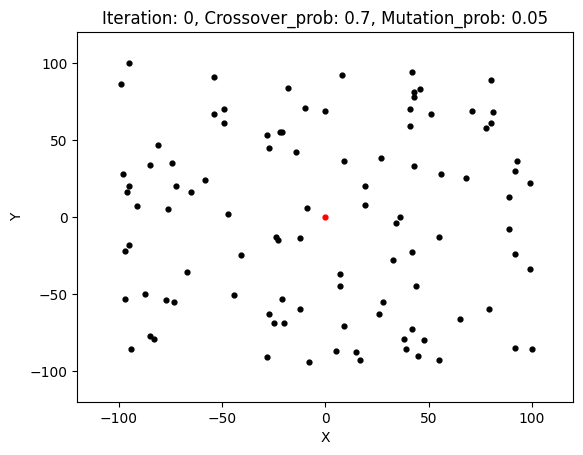

plot_for_indicators: [[-49, 70], [93, 36], [17, -93], [89, -8], [-76, 5], [65, -66], [-28, 53], [-22, 55], [41, 59], [-20, -69], [55, -93], [55, -13], [-23, -15], [-12, -60], [-94, -86], [-95, -18], [-24, -13], [5, -87], [42, -23], [-9, 6], [38, -79], [-12, -14], [-28, -91], [19, 8], [-10, 71], [-54, 67], [28, -55], [46, 83], [-74, 35], [-96, 16], [-91, 7], [-73, -55], [41, 70], [-25, -69], [-98, 28], [7, -45], [-95, 20], [-49, 61], [42, 94], [-95, 100], [-54, 91], [43, 78], [42, -73], [45, -90], [-81, 47], [100, -86], [44, -45], [89, 13], [34, -4], [33, -28], [-8, -94], [81, 68], [80, 89], [48, -80], [68, 25], [9, 36], [-87, -50], [99, -34], [27, 38], [-41, -25], [-72, 20], [92, -24], [92, -85], [7, -37], [92, 30], [-44, -51], [79, -60], [-21, -53], [9, -71], [-99, 86], [36, 0], [43, 81], [-77, -54], [-21, 55], [80, 61], [-18, 84], [99, 22], [78, 58], [-65, 16], [8, 92], [0, 69], [39, -86], [-58, 24], [-27, 45], [43, 33], [15, -88], [-85, -77], [26, -63], [56, 28], [-85, 34], [-83, -7

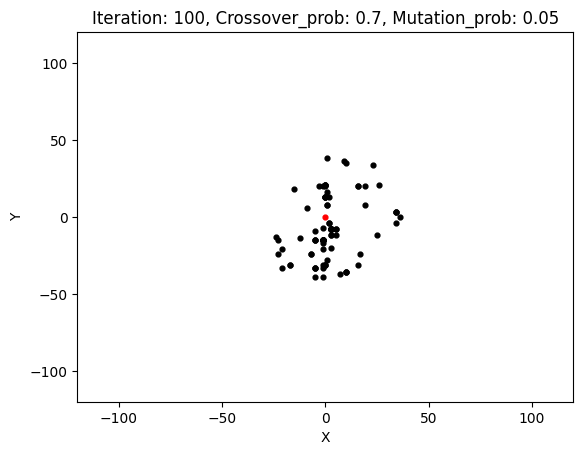

plot_for_indicators: [[-23, -15], [-24, -13], [-9, 6], [-12, -14], [19, 8], [34, -4], [9, 36], [7, -37], [36, 0], [19, 20], [25, -12], [-1, 20], [0, 21], [-1, -21], [2, 13], [3, -20], [0, 21], [26, 21], [-21, -33], [-1, -15], [-1, -15], [-1, -15], [1, 16], [-7, -24], [-7, -24], [10, 35], [1, -28], [-15, 18], [0, 13], [0, 13], [0, 13], [1, 8], [0, 21], [5, -12], [3, -8], [3, -8], [3, -8], [16, 20], [0, 21], [-21, -21], [-17, -31], [-1, -15], [23, 34], [0, -31], [0, -31], [5, -8], [3, -12], [5, -8], [3, -12], [-1, -15], [-17, -31], [16, 20], [0, -31], [17, -24], [-5, -15], [0, 20], [16, -31], [-3, 20], [-5, -33], [-5, -33], [-5, -33], [-1, -39], [-5, -9], [-23, -24], [-1, -31], [10, -36], [34, 3], [10, -36], [34, 3], [10, -36], [34, 3], [2, -4], [2, -4], [-1, -7], [1, 8], [0, 13], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [-1, -15], [3, -8], [-1, -15], [3, -8], [-1, -15], [3, -8], [-1, -15], [3, -8], [-1, -15], [-5, -15], [-1, -15], [-5, -15], [-1, -33], [-5

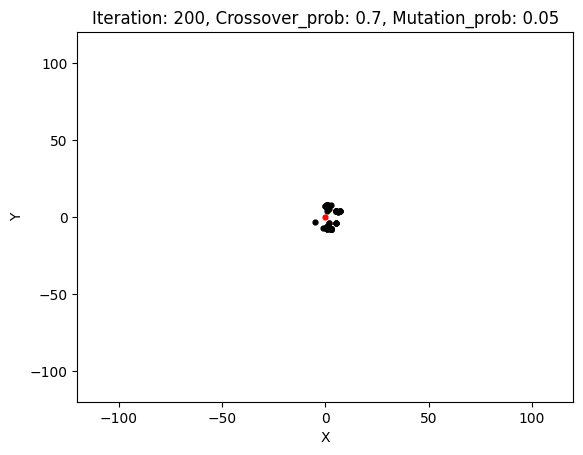

plot_for_indicators: [[1, 8], [3, -8], [3, -8], [3, -8], [2, -4], [2, -4], [-1, -7], [1, 8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [3, -8], [6, 3], [2, 7], [2, 7], [3, -8], [3, -8], [1, -8], [3, -8], [3, -8], [2, 7], [1, 8], [1, 8], [1, 8], [5, 4], [5, 4], [5, 4], [3, -8], [1, 4], [-5, -3], [6, 3], [1, -8], [3, -8], [3, -8], [2, 7], [2, 7], [7, 4], [7, 4], [3, -8], [5, 4], [5, -4], [5, -4], [0, -7], [0, 7], [0, 7], [3, -8], [3, -8], [1, 8], [5, 4], [5, 4], [1, -8], [3, -8], [1, 8], [1, 8], [1, 8], [1, 8], [1, 8], [3, -8], [3, -8], [1, 6], [1, 8], [3, -8], [7, 4], [1, 8], [1, 8], [3, 8], [5, 4], [1, 8], [5, 4], [1, 8], [5, 4], [1, 8], [5, 4], [1, 8], [5, 4], [1, 8], [5, 4], [1, -6], [5, 4], [2, 5], [7, 4], [5, 4], [5, -4], [3, -8], [5, -4], [3, -8], [1, 6], [1, 6], [1, 8], [1, 8], [1, 8], [1, 8]]
minimum value: 17.0


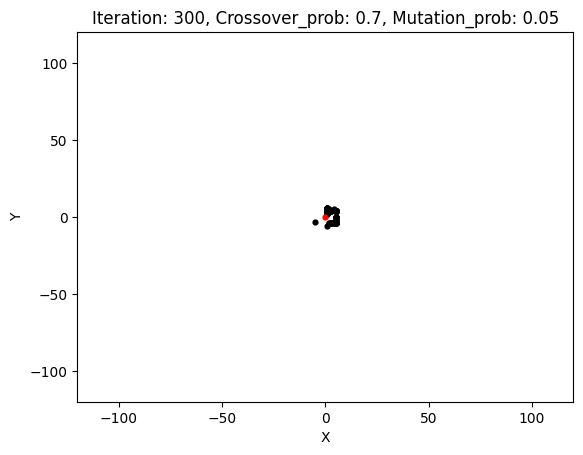

plot_for_indicators: [[2, -4], [2, -4], [5, 4], [5, 4], [5, 4], [1, 4], [-5, -3], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [1, 6], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [1, -6], [5, 4], [2, 5], [5, 4], [5, -4], [5, -4], [1, 6], [1, 6], [4, 5], [3, 4], [1, 4], [3, 4], [3, 4], [3, 4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [1, 4], [5, 0], [5, 0], [5, 0], [1, 2], [1, 2], [1, 2], [1, 2], [1, 6], [1, 6], [1, 4], [1, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [1, 4], [5, 4], [5, -4], [5, -4], [5, -4], [5, -4], [5, -4], [5, 4], [5, -2], [5, -2], [5, -4], [5, -4], [5, -4], [5, -4], [5, -4], [5, -2], [5, -4], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [5, 0], [5, 0], [3, -4], [4, -4]]
minimum value: 5.0


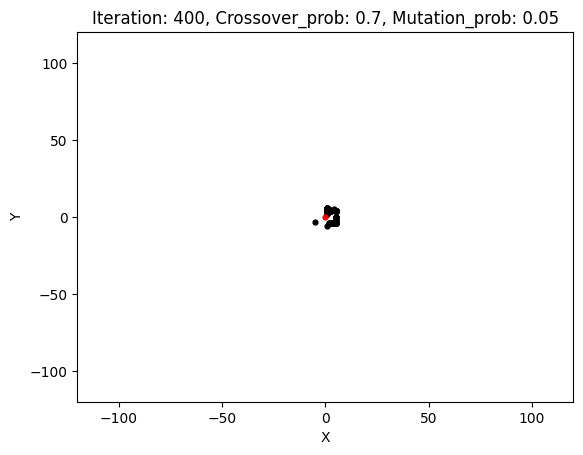

plot_for_indicators: [[2, -4], [2, -4], [5, 4], [5, 4], [5, 4], [1, 4], [-5, -3], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [1, 6], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [1, -6], [5, 4], [2, 5], [5, 4], [5, -4], [5, -4], [1, 6], [1, 6], [4, 5], [3, 4], [1, 4], [3, 4], [3, 4], [3, 4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [1, 4], [5, 0], [5, 0], [5, 0], [1, 2], [1, 2], [1, 2], [1, 2], [1, 6], [1, 6], [1, 4], [1, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [1, 4], [5, 4], [5, -4], [5, -4], [5, -4], [5, -4], [5, -4], [5, 4], [5, -2], [5, -2], [5, -4], [5, -4], [5, -4], [5, -4], [5, -4], [5, -2], [5, -4], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [5, 0], [5, 0], [3, -4], [4, -4]]
minimum value: 5.0


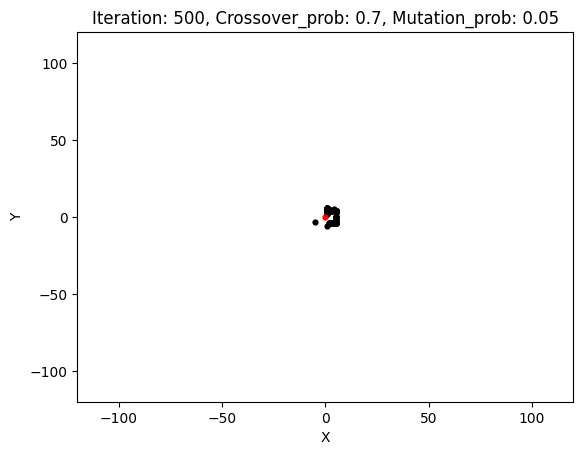

plot_for_indicators: [[2, -4], [2, -4], [5, 4], [5, 4], [1, 4], [-5, -3], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [1, 6], [5, 4], [5, 4], [5, 4], [5, 4], [1, -6], [5, 4], [2, 5], [5, 4], [5, -4], [5, -4], [1, 6], [1, 6], [4, 5], [3, 4], [1, 4], [3, 4], [3, 4], [3, 4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [1, 4], [5, 0], [5, 0], [5, 0], [1, 2], [1, 2], [1, 2], [1, 2], [1, 6], [1, 6], [1, 4], [1, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [1, 4], [5, -4], [5, -4], [5, -4], [5, 4], [5, -2], [5, -2], [5, -4], [5, -4], [5, -4], [5, -4], [5, -4], [5, -2], [5, -4], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [5, 0], [5, 0], [3, -4], [4, -4], [3, -4], [3, -4], [5, 2], [5, 4], [1, 4], [5, 4], [1, 4], [5, 4], [1, 4]]
minimum value: 5.0


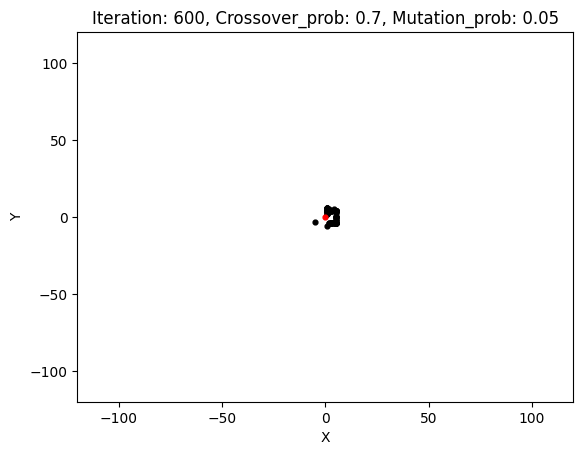

plot_for_indicators: [[2, -4], [2, -4], [5, 4], [5, 4], [1, 4], [-5, -3], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [1, 6], [5, 4], [5, 4], [5, 4], [5, 4], [1, -6], [5, 4], [2, 5], [5, 4], [5, -4], [5, -4], [1, 6], [1, 6], [4, 5], [3, 4], [1, 4], [3, 4], [3, 4], [3, 4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [1, 4], [5, 0], [5, 0], [5, 0], [1, 2], [1, 2], [1, 2], [1, 2], [1, 6], [1, 6], [1, 4], [1, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [5, 4], [1, 4], [5, -4], [5, -4], [5, -4], [5, 4], [5, -2], [5, -2], [5, -4], [5, -4], [5, -4], [5, -4], [5, -4], [5, -2], [5, -4], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [5, 0], [5, 0], [3, -4], [4, -4], [3, -4], [3, -4], [5, 2], [5, 4], [1, 4], [5, 4], [1, 4], [5, 4], [1, 4]]
minimum value: 5.0


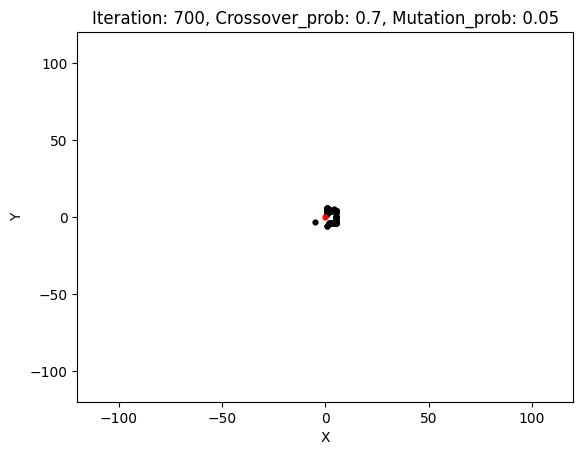

plot_for_indicators: [[2, -4], [2, -4], [5, 4], [5, 4], [1, 4], [-5, -3], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [1, 6], [5, 4], [5, 4], [5, 4], [5, 4], [1, -6], [5, 4], [2, 5], [5, 4], [5, -4], [5, -4], [1, 6], [1, 6], [4, 5], [3, 4], [1, 4], [3, 4], [3, 4], [3, 4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [4, -4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [3, -4], [5, 4], [1, 4], [5, 0], [5, 0], [5, 0], [1, 2], [1, 2], [1, 2], [1, 2], [1, 6], [1, 6], [1, 4], [1, 4], [5, 4], [5, 4], [1, 4], [5, -4], [5, -4], [5, -4], [5, 4], [5, -2], [5, -2], [5, -4], [5, -4], [5, -4], [5, -4], [5, -4], [5, -2], [5, -4], [5, 4], [5, -4], [5, -4], [5, 4], [5, 4], [5, 0], [5, 0], [3, -4], [4, -4], [3, -4], [3, -4], [5, 2], [5, 4], [1, 4], [5, 4], [1, 4], [5, 4], [1, 4], [1, 5], [1, 4], [5, 4], [5, 0], [5, 4], [1, 4], [5, 4], [1, -6], [5, 0], [5, 0]]
minimum value: 5.0


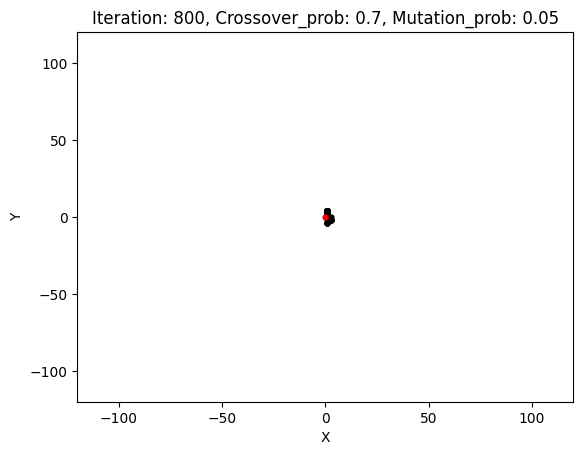

plot_for_indicators: [[1, 4], [1, 4], [1, 4], [1, 2], [1, 2], [1, 2], [1, 2], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 2], [1, 2], [1, 2], [1, 2], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 0], [1, 0], [1, 2], [1, 2], [1, 4], [1, 4], [3, -2], [1, 0], [1, 4], [1, 4], [1, 4], [1, 4], [1, 0], [1, 4], [1, 4], [1, 4], [1, 2], [1, 2], [1, 2], [1, 2], [1, 4], [1, 0], [1, 4], [1, 4], [1, 4], [1, 4], [1, 2], [3, -2], [1, 4], [3, -2], [1, 4], [3, -2], [1, 4], [1, 0], [3, -2], [1, -4], [1, -4], [1, 4], [1, 4], [1, 2], [1, 0], [1, 4], [1, 4], [1, 2], [1, 4], [1, 2], [1, 4], [1, 4], [1, 4], [1, -2], [1, 2], [1, -4], [1, -4], [3, 0], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 4], [1, 2]]
minimum value: 1.0


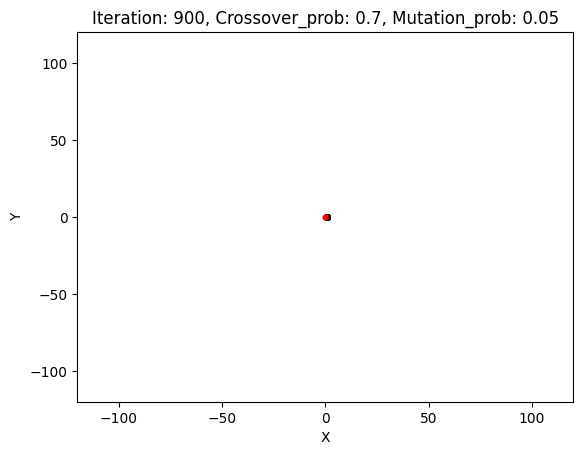

plot_for_indicators: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
minimum value: 1.0


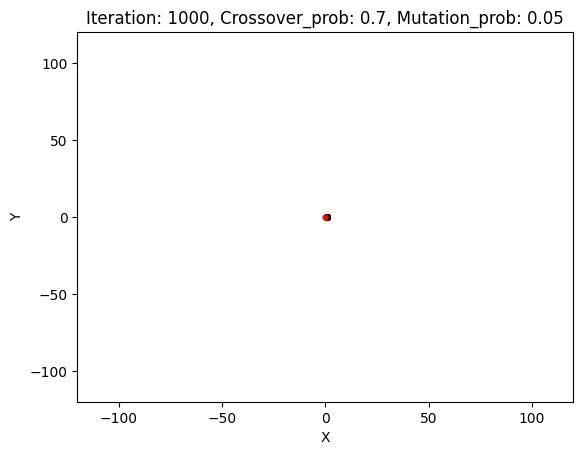

plot_for_indicators: [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
minimum value: 1.0


In [71]:
"""
Generate intial population
"""

list_for_plot = []

#
solution_set = []
successful_pop = 1
while successful_pop <= num_pop:
    
    # Generate    
    temp_solution_set = []
    success_dim = 0
    while success_dim < dimension:
        temp_chromosome = generate_random_solution(size)
        val = chromosome_bin_to_decimal(temp_chromosome)
    
        # for the warm initial solution: -100 ~ +100
        if (val >= -100) &  (val <= 100):
            temp_solution_set.append(temp_chromosome)
            success_dim = success_dim + 1
        else:
            pass
            # print(f'Infeasible!...')
    # Append
    solution_set.append(temp_solution_set)
    # print(f'Generated num of population: {successful_pop}')
    
    # Update
    successful_pop = successful_pop + 1

iteration = 0
basis_plot(solution_set, iteration)



iteration = 1
while iteration <= MAX_ITR:

    """
    Set the roulette-wheel and select two individual solutions
    """

    # selection probability based on fitness values
    
    selection_prob = calculate_obj_and_compose_selection_probability(solution_set)
    # selection_prob = calculate_obj_and_compose_selection_probability_fitnessvalue(solution_set)

    # 1~Npop
    num_list = list(range(0,num_pop))
    selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)
    # print(selected_pop)

    """
    Execute crossover with crossover probability: select only two
    """
    # Selected two solutions
    solution_1 = solution_set[selected_pop[0]]
    solution_2 = solution_set[selected_pop[1]]
    # print(f'current\n{solution_1}\n{solution_2}')

    if random.random() <= crossover_prob:
        new_solution_1, new_solution_2 = execute_crossover_standard(solution_1, solution_2)
        # print(f'new\n{new_solution_1}\n{new_solution_2}')

    """
    Execute muatation with crossover probability: select only one solution between two solutions
    """

    # print(f'current\n{new_solution_1}\n{new_solution_2}')
    if random.random() <= mutation_prob: # mutation_prob
        new_solution_1, new_solution_2 = execute_mutation_standard(new_solution_1, new_solution_2)
    # print(f'current\n{new_solution_1}\n{new_solution_2}')


    """
    Alternative I or II
    """
    solution_set = alternative_2(solution_set, new_solution_1, new_solution_2)    
    
    
    """
    Evaluation
    """
    iterative_solution_set = calculate_objective_function(solution_set)
    
    # print(f'{iteration} | Best solution {solution_set[iterative_solution_set.index(min(iterative_solution_set))]}, value: {min(iterative_solution_set)}, index: {iterative_solution_set.index(min(iterative_solution_set))}')
    list_for_plot.append(min(iterative_solution_set))
    
    """
    Basis plot
    """
    if iteration%100 == 0:
        basis_plot(solution_set, iteration)
        
        
    
    # Update
    iteration = iteration + 1



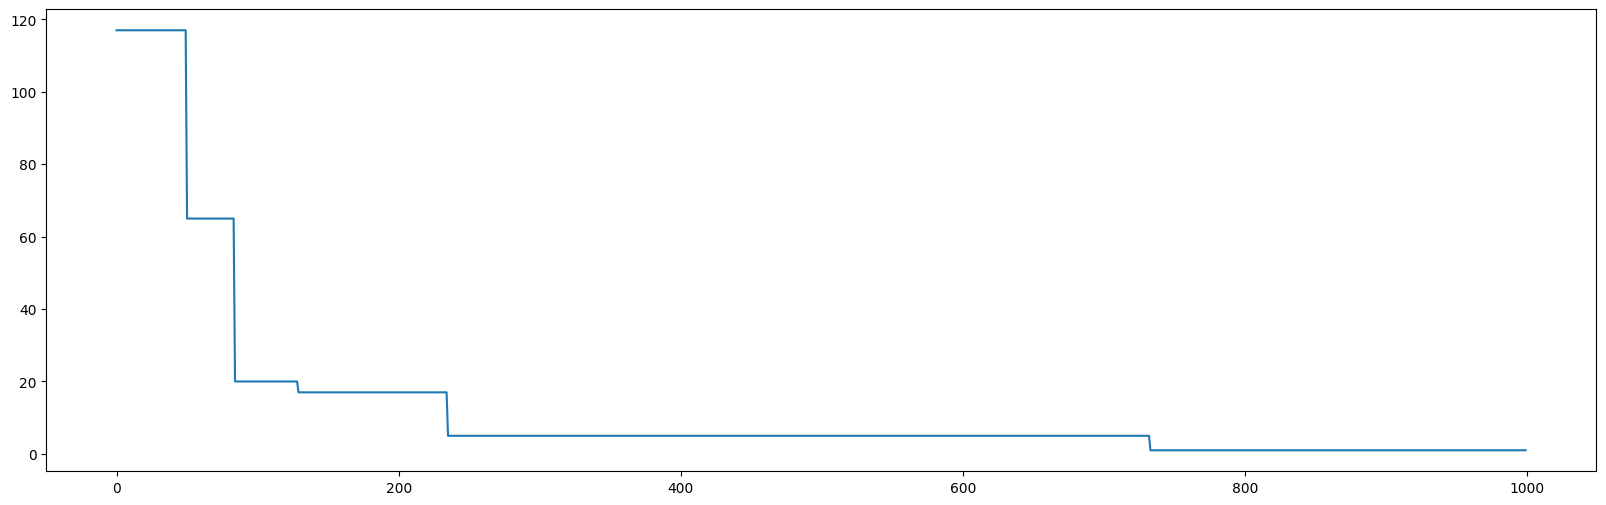

In [72]:
plt.figure(figsize=(20,6))
plt.plot(list_for_plot)
plt.show()

In [552]:
"""
Develop indicators(Exploration/Exploitation)
"""

'\nDevelop indicators(Exploration/Exploitation)\n'

## Dev note
- 전반적으로 오류나는거 체크(len 범위 착각)
- selection 할때 1, 2등에 거의 몰빵해야 함 예) 50*(1/2)**(r-100)
- Update하고 나서 feasibility 체크 따로 안 해도 될까?

In [722]:
for r in range(0, 100):
    print(50*(0.5)**(r))

50.0
25.0
12.5
6.25
3.125
1.5625
0.78125
0.390625
0.1953125
0.09765625
0.048828125
0.0244140625
0.01220703125
0.006103515625
0.0030517578125
0.00152587890625
0.000762939453125
0.0003814697265625
0.00019073486328125
9.5367431640625e-05
4.76837158203125e-05
2.384185791015625e-05
1.1920928955078125e-05
5.9604644775390625e-06
2.9802322387695312e-06
1.4901161193847656e-06
7.450580596923828e-07
3.725290298461914e-07
1.862645149230957e-07
9.313225746154785e-08
4.6566128730773926e-08
2.3283064365386963e-08
1.1641532182693481e-08
5.820766091346741e-09
2.9103830456733704e-09
1.4551915228366852e-09
7.275957614183426e-10
3.637978807091713e-10
1.8189894035458565e-10
9.094947017729282e-11
4.547473508864641e-11
2.2737367544323206e-11
1.1368683772161603e-11
5.6843418860808015e-12
2.8421709430404007e-12
1.4210854715202004e-12
7.105427357601002e-13
3.552713678800501e-13
1.7763568394002505e-13
8.881784197001252e-14
4.440892098500626e-14
2.220446049250313e-14
1.1102230246251565e-14
5.551115123125783e-15
2

In [673]:
print(len(selection_prob))

num_list = list(range(1,(num_pop+1)))
selected_pop = np.random.choice(num_list, 2, p=selection_prob, replace=False)



100


ValueError: probabilities contain NaN